### Import necessary libraries

In [10]:
!export TORCH_HOME=.cache/

In [18]:
import torch
import torchvision
import time
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms
from pathlib import Path
import os


In [19]:
os.environ['TORCH_HOME'] = '.cache/'

### Function to load the DINOv2 model and move it to the specified device (CPU or GPU)

In [20]:
def load_dinov2(device):
    model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')  # Load DINOv2 model from PyTorch Hub
    model = model.to(device)  # Move the model to the specified device
    model.eval()  # Set model to evaluation mode
    return model

### Function to prepare the dataset with the appropriate transformations and data loader

In [21]:
def prepare_data(batch_size=32):
    # Define transformations: resize, convert to tensor, and normalize image data
    transform = transforms.Compose([
        transforms.Resize(224),  # Resize image to 224x224 pixels
        transforms.ToTensor(),  # Convert image to a tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalization mean
                             std=[0.229, 0.224, 0.225])  # Normalization standard deviation
    ])
    
    # Specify the directory of the dataset
    data_dir = Path("./tiny-imagenet-200/tiny-imagenet-200/test")
    # Load the dataset and apply transformations
    dataset = torchvision.datasets.ImageFolder(data_dir, transform=transform)
    # Create a DataLoader for batching and shuffling the data
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return loader

### Function to benchmark the model performance in terms of inference time

In [22]:
def benchmark_model(model, test_loader, device, num_batches=100, use_amp=False):
    times = []  # List to store inference times
    model = model.to(device)  # Move model to device (CPU/GPU)

    with torch.no_grad():  # Disable gradient computation
        for i, (images, _) in enumerate(test_loader):  # Iterate over batches
            if i >= num_batches:  # Limit the number of batches for benchmarking
                break
            
            images = images.to(device)  # Move images to the specified device
            
            # Warmup GPU by performing a dummy forward pass on the first batch
            if i == 0 and device.type == 'cuda':
                _ = model(images)
                torch.cuda.synchronize()  # Synchronize GPU operations
                continue  # Skip timing for this warmup iteration

            start = time.time()  # Start timing
            
            # Perform inference with mixed precision if use_amp is True
            with torch.cuda.amp.autocast(enabled=use_amp):  # Mixed precision context
                _ = model(images)
                
            torch.cuda.synchronize()  # Ensure all GPU operations are finished
            end = time.time()  # End timing
            
            times.append(end - start)  # Record elapsed time
    
    # Return the average inference time
    return sum(times) / len(times)

### Execute the benchmark process

In [23]:
def main():
    # Check if CUDA is available; if not, display an error and exit
    if not torch.cuda.is_available():
        print("CUDA is not available. This script requires a GPU.")
        return

    device = torch.device("cuda")  # Set device to GPU
    torch.backends.cudnn.benchmark = True  # Enable cuDNN benchmarking for performance
    
    # Load model and data
    model = load_dinov2(device)  # Load DINOv2 model
    test_loader = prepare_data()  # Prepare test data loader
    
    # Benchmark original model in FP32 precision
    print("Benchmarking original model in FP32...")
    orig_time_fp32 = benchmark_model(model, test_loader, device, use_amp=False)

    # Benchmark model in mixed precision (FP16)
    print("Benchmarking model with mixed precision (FP16)...")
    orig_time_fp16 = benchmark_model(model, test_loader, device, use_amp=True)

    # Calculate speedup between FP32 and FP16
    speedup = orig_time_fp32 / orig_time_fp16
    
    # Print results for both precision settings and speedup
    print("\nResults:")
    print(f"Original model inference time (FP32): {orig_time_fp32 * 1000:.2f} ms")
    print(f"Mixed precision model inference time (FP16): {orig_time_fp16 * 1000:.2f} ms")
    print(f"Speedup from FP32 to FP16: {speedup:.2f}x")

    # Plotting the results
    plt.figure(figsize=(10, 5))
    labels = ['FP32', 'FP16']
    times = [orig_time_fp32 * 1000, orig_time_fp16 * 1000]  # Convert to milliseconds
    colors = ['skyblue', 'lightgreen']
    
    # Plot a bar chart for FP32 and FP16 inference times
    bars = plt.bar(labels, times, color=colors)
    plt.ylabel('Inference Time (ms)')
    plt.title('Inference Time Comparison: FP32 vs FP16')
    
    # Add inference time text on each bar
    for bar, time in zip(bars, times):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, 
                 f"{time:.2f} ms", ha='center', va='center', color='black', fontsize=12)
    
    # Display speedup text on the plot
    plt.figtext(0.8, 0.8, f"Speedup: {speedup:.2f}x", fontsize=12, ha='right')

    # Save the plot as an image file and display it
    plt.savefig("inference.png")  # Save the figure as "inference.png"
    plt.show()  # Show the plot


Using cache found in .cache/hub/facebookresearch_dinov2_main
/home/z004x2xz/miscExcersises/himanshushukla12/ML-Engineer-Challenge/.cache/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/z004x2xz/miscExcersises/himanshushukla12/ML-Engineer-Challenge/.cache/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/z004x2xz/miscExcersises/himanshushukla12/ML-Engineer-Challenge/.cache/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


Benchmarking original model in FP32...


/tmp/ipykernel_577508/1704632255.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):  # Mixed precision context


Benchmarking model with mixed precision (FP16)...

Results:
Original model inference time (FP32): 17.71 ms
Mixed precision model inference time (FP16): 8.19 ms
Speedup from FP32 to FP16: 2.16x


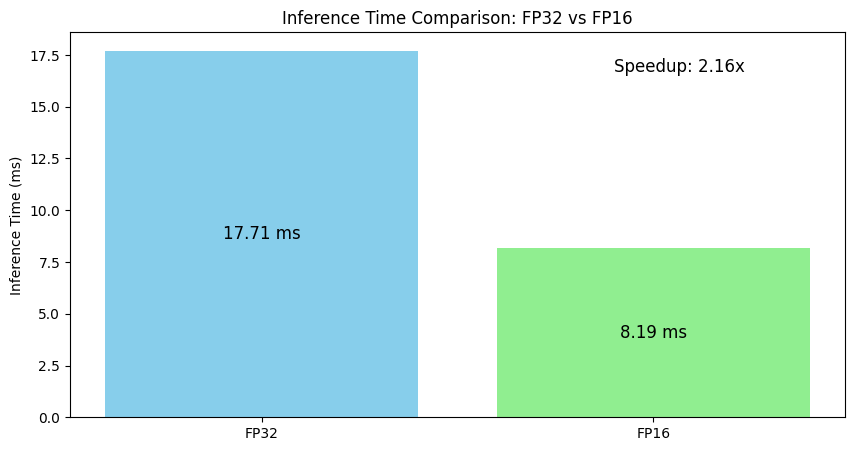

In [24]:
main()